### Libraries 

In [101]:
import pandas as pd
import chardet
import yfinance as yf
import os
import numpy as np
import sys
import datetime

### Functions 

In [102]:
def remove_weekends(df): 
    """Remove weekends from a DataFrame.""" 
    if not isinstance(df.index, pd.DatetimeIndex): 
        df.index = pd.to_datetime(df.index) 

    return df[df.index.weekday < 5]

def get_latest_entry_per_month(df):
    """
    Get the latest entry for each month in a DataFrame.
    """
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    
    # sort the DataFrame by index to ensure chronological order
    df_sorted = df.sort_index()
    # Group by year and month, then get the last entry for each group
    latest_entries = df_sorted.groupby([df_sorted.index.year, df_sorted.index.month]).tail(1)

    return latest_entries


# define the risk-free rate for some KPIs (Take the Euribor 3M as the rfrate)
risk_free_rate = 0.02

# define a start date 
start_date_benchmark = datetime.datetime(2019, 9, 1)
start_date = datetime.datetime(2020, 1, 1)
current_date = datetime.datetime.now()

#### Decryption Code (Portfolio Wikifolio)

In [103]:

# Define the file path
file_path = r"C:\Users\Sebastian Kaiser\Desktop\FNI\IG\project_Dashboard\Triple_Three_Dashboard\Portfolio_Price_Data_Wikifolio\WFIRM20FNI-PriceData-20250812175244.csv"

# Encoding erkennen
with open(file_path, 'rb') as f:
    encoding = chardet.detect(f.read(10000))['encoding']

# Header-Zeile finden
with open(file_path, 'r', encoding=encoding) as f:
    lines = [line.strip() for line in f if line.strip()]
    header_index = next(i for i, line in enumerate(lines) if 'Begin date' in line)

# Datei einlesen
data_raw = pd.read_csv(
    file_path,
    sep=';',
    encoding=encoding,
    skiprows=header_index,
    header=0,
    engine='python'
)

# Spalten setzen (DateTime ist bereits kombiniert)
data_raw.columns = ['DateTime', 'Interval', 'Open', 'Close', 'High', 'Low']

# Datum konvertieren
data_raw['DateTime'] = pd.to_datetime(data_raw['DateTime'], dayfirst=True, errors='coerce')

# Zahlen bereinigen
for col in ['Open', 'Close', 'High', 'Low']:
    data_raw[col] = (
        data_raw[col]
        .astype(str)
        .str.replace(r'\s+', '', regex=True)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

# Index setzen und Interval ggf. löschen
data_raw.set_index('DateTime', inplace=True)
data_raw.drop(columns=['Interval'], inplace=True)

# Ausgabe
print(data_raw.head())


               Open    Close     High      Low
DateTime                                      
2019-09-01  100.000  100.000  100.000  100.000
2019-09-02   99.997   99.997   99.997   99.997
2019-09-03   99.995   99.811   99.995   99.634
2019-09-04   99.967  100.321  100.702   99.967
2019-09-05  100.714  100.972  101.067  100.647


In [104]:
# Import the benchmark (MSCI World Growth Index via Yahoo Finance)
ticker = "^105867-USD-STRD"

benchmark = yf.download(
    ticker,
    start=start_date_benchmark,
    end=current_date,
    interval='1d',
    group_by='ticker'
)

# Falls MultiIndex → nur "Close"
if isinstance(benchmark.columns, pd.MultiIndex):
    benchmark = benchmark.xs('Close', axis=1, level=1)
else:
    benchmark = benchmark[['Close']]

benchmark.columns = ['Close']


[*********************100%***********************]  1 of 1 completed


### Adjustments

In [105]:
# leave only the Close column for further calculations
Close = 'Close'
# Adjust the data to only include the Close prices  
data_adjusted = data_raw[Close]

## Calculations & KPIs

#### Total Return 

In [106]:
# Total return 
total_return = (data_adjusted.iloc[-1]/ data_adjusted.iloc[0]) - 1

#### CAGR

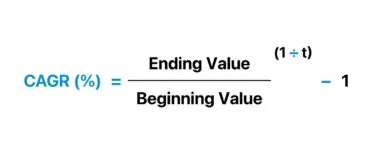

In [107]:
# CAGR
days = (data_adjusted.index[-1] - data_adjusted.index[0]).days
total_return = (data_adjusted.iloc[-1] / data_adjusted.iloc[0]) - 1
cagr = (1 + total_return) ** (365 / days) - 1

#### Annualized Vola

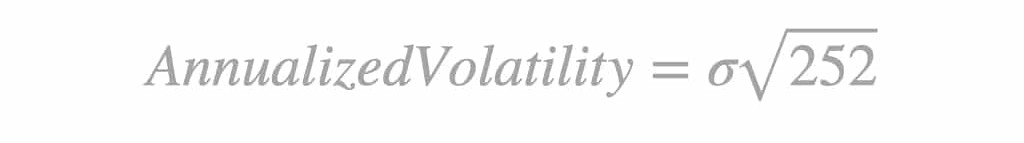

In [108]:
# annualized volatility
annual_volatility = data_adjusted.pct_change().std() * np.sqrt(252)

#### Downside Risk

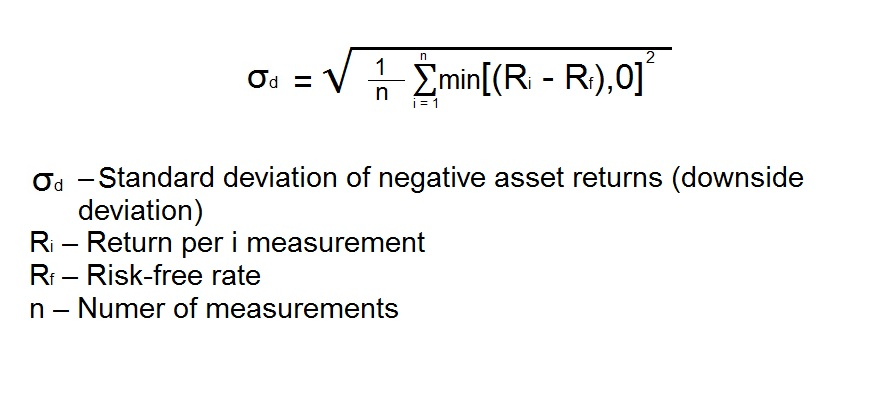

In [109]:
# Downside risk
downside_returns = data_adjusted.pct_change()[data_adjusted.pct_change() < 0]
downside_risk = downside_returns.std() * np.sqrt(252)

#### Sharpe Ratio

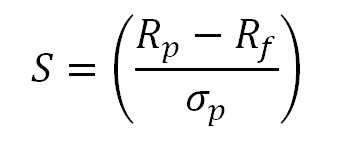

In [110]:
# sharpe ratio
sharpe_ratio = (data_adjusted.pct_change().mean() - risk_free_rate / 252) / annual_volatility

#### Sortino Ratio

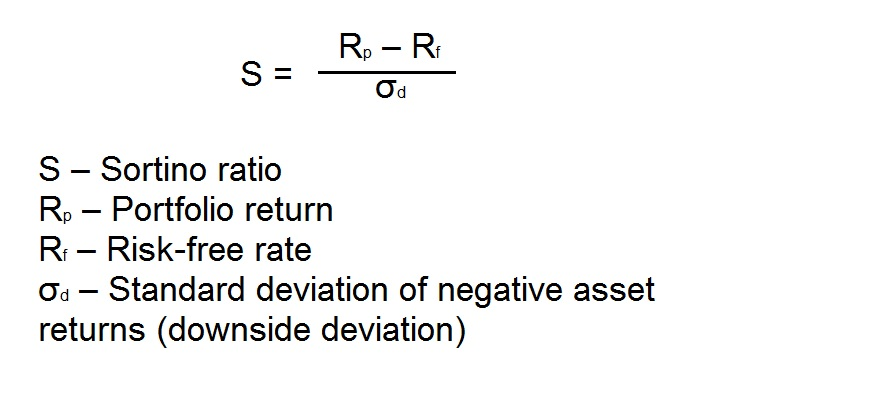

In [111]:
# Sortino ratio
downside_returns = data_adjusted.pct_change()[data_adjusted.pct_change() < 0]
sortino_ratio = (data_adjusted.pct_change().mean() - risk_free_rate / 252) / downside_returns.std()

#### Max Drawdown

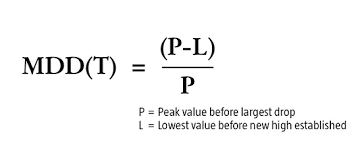

In [112]:
# Max Drawdown
rolling_max = data_adjusted.cummax()
drawdown = (data_adjusted - rolling_max) / rolling_max
max_drawdown = drawdown.min()

#### Beta

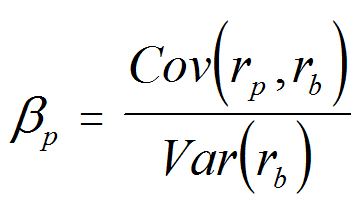

In [113]:
# Daily Returns als Series
portfolio_daily_returns_series = portfolio_daily_returns.dropna()
benchmark_daily_returns_series = benchmark_daily_returns.dropna()# Series

# Nur gemeinsame Handelstage
common_dates = portfolio_daily_returns_series.index.intersection(benchmark_daily_returns_series.index)
portfolio_daily_returns_series = portfolio_daily_returns_series.loc[common_dates]
benchmark_daily_returns_series = benchmark_daily_returns_series.loc[common_dates]

# Beta berechnen
cov_matrix = np.cov(portfolio_daily_returns_series, benchmark_daily_returns_series)
beta = cov_matrix[0, 1] / cov_matrix[1, 1]

#### Jensen's Alpha (annual)

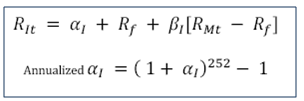

In [158]:
# Länge des Zeitraums in Jahren
years = (common_dates[-1] - common_dates[0]).days / 365.25

# Annualisierte Total Returns
portfolio_annual_return = (1 + portfolio_total_return) ** (1 / years) - 1
benchmark_annual_return = (1 + benchmark_total_return) ** (1 / years) - 1

# Annualisierte erwartete Rendite
expected_annual_return = risk_free_rate + beta * (benchmark_annual_return - risk_free_rate)

# Annualisiertes Jensen's Alpha
jensens_alpha_annualized = portfolio_annual_return - expected_annual_return

jensens_alpha_annualized = jensens_alpha_annualized.item()

# ouput only the number


In [159]:
jensens_alpha_annualized 


-0.045852099996799095

#### Export KPIs to list 

In [160]:
kpis = pd.DataFrame({
    'Total Return': [total_return],
    'CAGR': [cagr],
    'Annualized Volatility': [annual_volatility],
    'Downside Risk': [downside_risk],
    'Sharpe Ratio': [sharpe_ratio],
    'Sortino Ratio': [sortino_ratio],
    'Max Drawdown': [max_drawdown],
    'Beta': [beta],
    'Jensen/s Alpha': [jensens_alpha_annualized],
})


In [116]:
kpis

,Total Return,CAGR,Annualized Volatility,Downside Risk,Sharpe Ratio,Sortino Ratio,Max Drawdown,Beta,Jensen/s Alpha
0,0.53255,0.074382,0.166215,0.139064,0.001154,0.021896,-0.324936,0.737506,Close -0.045852 dtype: float64


#### Performance History (Portfolio)

In [117]:
# remove the weejends from the data
data_adjusted = remove_weekends(data_adjusted)

# calculate the percentage change of the Portfolio
data_pct_change = data_adjusted.pct_change() + 1
data_cumprod = data_pct_change.cumprod()

data_cumprod.iloc[0] = 1

data_final = data_cumprod - 1

# melt the DataFrame to have a long format
data_final_melted = data_final.reset_index().melt(id_vars='DateTime', var_name='Portfolio', value_name='Cumulative Return')

# drop the 'Portfolio' column as it is not needed
data_final_melted.drop(columns=['Portfolio'], inplace=True)

#### Performance History (Benchmark)

In [118]:
# 1. NaNs entfernen
benchmark = benchmark.dropna(subset=['Close'])

# 2. Prozentänderung
benchmark_pct_change = benchmark['Close'].pct_change()

# 3. YTD oder gesamte Cumulative Return
benchmark_cumprod = (1 + benchmark_pct_change).cumprod()

# 4. Ersten Wert auf 1 setzen
benchmark_cumprod.iloc[0] = 1

# 5. In Prozent-Format
benchmark_final = benchmark_cumprod - 1

# 6. Prepare the benchmark DataFrame
benchmark_final = benchmark_final.reset_index().rename(columns={'Date': 'DateTime', 'Close': 'Cumulative Return_bm'})

# 7. Merge the data with the benchmark
merged_data = pd.merge(data_final_melted, benchmark_final, on='DateTime', how='outer')


In [119]:
merged_data

,DateTime,Cumulative Return,Cumulative Return_bm
0,2019-09-02,0.000000,NaN
1,2019-09-03,-0.001860,0.000000
2,2019-09-04,0.003240,0.010506
3,2019-09-05,0.009750,0.023223
4,2019-09-06,0.010090,0.024687
...,...,...,...
1534,2025-08-11,0.524266,1.359378
1535,2025-08-12,0.532596,1.381948
1536,2025-08-13,NaN,1.387520
1537,2025-08-14,NaN,1.387876


### EOM Performance 2025

##### Portfolio

In [144]:
# 1. Series in DataFrame konvertieren (optional)
if isinstance(data_pct_change, pd.Series):
    data_pct_change = data_pct_change.to_frame(name='Close')

# 2. Sicherstellen, dass der Index DatetimeIndex ist
if not isinstance(data_pct_change.index, pd.DatetimeIndex):
    data_pct_change.index = pd.to_datetime(data_pct_change.index)

# 3. Nur Daten ab 2025
data_2025 = data_pct_change[data_pct_change.index.year == 2025].copy()

if data_2025.empty:
    raise ValueError("Keine Daten für 2025 vorhanden!")

# 4. YTD Performance berechnen: kumuliert ab Jahresbeginn
# Da Close schon daily pct_change + 1 ist, cumprod() startet bei 1
data_2025['YTD_Performance'] = data_2025['Close'].cumprod() - 1
data_2025['YTD_Performance'] *= 100  # in Prozent

# 5. Letzten Eintrag jedes Monats speichern
monthly_last = data_2025.resample('ME').last()

monthly_last['Portfolio'] = 'FNI Triple Three Growth'

# 7. drop the Close column as it is not needed
monthly_last.drop(columns=['Close'], inplace=True)


##### Benchmark

In [145]:
# Falls Series, in DataFrame konvertieren
if isinstance(benchmark_pct_change, pd.Series):
    benchmark_pct_change = benchmark_pct_change.to_frame(name='Close')

# Sicherstellen, dass Index ein DatetimeIndex ist
if not isinstance(benchmark_pct_change.index, pd.DatetimeIndex):
    benchmark_pct_change.index = pd.to_datetime(benchmark_pct_change.index)

# Nur Daten ab 2025
benchmark_2025 = benchmark_pct_change[benchmark_pct_change.index.year == 2025].copy()
if benchmark_2025.empty:
    raise ValueError("Keine Benchmark-Daten für 2025 vorhanden!")

# YTD Performance berechnen
benchmark_2025['YTD_Performance_bm'] = (benchmark_2025['Close'] + 1).cumprod() - 1
benchmark_2025['YTD_Performance_bm'] *= 100  # in Prozent

# Monatsendwerte
benchmark_monthly_last = benchmark_2025.resample('ME').last().reset_index()

benchmark_monthly_last['Portfolio'] = 'MSCI World Growth Index'

#drop the 'Close' column as it is not needed
benchmark_monthly_last.drop(columns=['Close'], inplace=True)


In [147]:
print(monthly_last.columns)
print(benchmark_monthly_last.columns)


Index(['YTD_Performance', 'Portfolio'], dtype='object')
Index(['Date', 'YTD_Performance_bm', 'Portfolio'], dtype='object')


##### Merge

In [153]:
# Benchmark: 'Date' → 'DateTime'
benchmark_monthly_last = benchmark_monthly_last.rename(columns={'Date':'DateTime'})

# Merge
monthly_merged = pd.merge(
    monthly_last,
    benchmark_monthly_last,
    on='DateTime',
    how='outer',
    suffixes=('_portfolio', '_benchmark')
)


monthly_long = monthly_merged.melt(
    id_vars=['DateTime'], 
    value_vars=['YTD_Performance', 'YTD_Performance_bm'], 
    var_name='Metric', 
    value_name='YTD'
)

# Optional: Portfolio-Name korrekt zuordnen
monthly_long['Portfolio'] = monthly_long['Metric'].map({
    'YTD_Performance': 'FNI Triple Three Growth',
    'YTD_Performance_bm': 'MSCI World Growth Index'
})

# Metric-Spalte ist jetzt nicht mehr nötig
monthly_long = monthly_long.drop(columns=['Metric'])

#set the DateTime as index
monthly_long.set_index('DateTime', inplace=True)

In [154]:
monthly_long

,YTD,Portfolio
DateTime,,
2025-01-31,6.537934,FNI Triple Three Growth
2025-02-28,3.799171,FNI Triple Three Growth
2025-03-31,-3.011888,FNI Triple Three Growth
2025-04-30,-3.861990,FNI Triple Three Growth
2025-05-31,2.465637,FNI Triple Three Growth
2025-06-30,1.568421,FNI Triple Three Growth
2025-07-31,4.245731,FNI Triple Three Growth
2025-08-31,4.644493,FNI Triple Three Growth
2025-01-31,2.634941,MSCI World Growth Index


## Single Stocks

#### Path

In [162]:
stock_data = pd.read_excel(r"C:\Users\Sebastian Kaiser\Desktop\FNI\IG\project_Dashboard\Triple_Three_Dashboard\Stock_Price_Data\TripleThree_Stock_Data.xlsx")

In [163]:
stock_data

,Time Series Name,Resort,Ticker,Buy Date,Manager
0,Watsco,Consumption,WSO,2024-01-18,Clara Ostermann
1,Stride,Consumption,LRN,2024-06-13,Jasper Schneider
2,L'Oreal,Consumption,OR,2020-04-24,Nico Stumpf
3,Aixtron,Diamonds,AIXA.DE,2024-01-18,Ivan Nivievskyi
4,Prysmian,Diamonds,PRY.MI,2023-10-26,Ivan Nivievskyi
5,Zoetis,Healthcare,ZTS,2021-06-23,Lars Dankert
6,Medistim,Healthcare,MEDI.OL,2024-06-13,Lars Dankert
7,Siemens Healthineers,Healthcare,SHL.DE,2019-09-03,Jonas Kadmiry
8,Qualys,IT,QLYS,2022-01-31,Felix von dem Busche
9,Deutsche Telekom,Diamonds,DTE.DE,2022-10-17,Jasper Schneider


#### Import & Cumprod

In [201]:
# 1️⃣ List of tickers
tickers = stock_data['Ticker'].to_list()

# 2️⃣ Earliest buy date
start_date_stock = stock_data['Buy Date'].min()

# 3️⃣ Download only Close prices
stock_prices = yf.download(tickers, start=start_date_stock)['Close']

# 4️⃣ If only one ticker, make it a DataFrame
if isinstance(stock_prices, pd.Series):
    stock_prices = stock_prices.to_frame()

# 5️⃣ Rename columns to match Time Series Name
stock_prices.columns = stock_data['Time Series Name'].to_list()

# 6️⃣ Convert buy dates to datetime
stock_data['Buy Date'] = pd.to_datetime(stock_data['Buy Date'])

# 7️⃣ Calculate cumulative returns from buy dates
stock_cum_returns = pd.DataFrame(index=stock_prices.index)

for name, buy_date in zip(stock_data['Time Series Name'], stock_data['Buy Date']):
    # Cum Return nur ab Buy-Date berechnen
    prices_filtered = stock_prices.loc[stock_prices.index >= buy_date, name]
    prices_filtered = prices_filtered.ffill()

    cum = (prices_filtered.pct_change(fill_method=None) + 1).cumprod()
    cum.iloc[0] = 1
    stock_cum_returns[name] = cum - 1

# Jetzt haben wir für vor dem Buy-Date einfach keine Spalte
# → mit reindex auf den Gesamtindex setzen wir dort NaN
stock_cum_returns = stock_cum_returns.reindex(stock_prices.index)



# 8️⃣ Melt to long format for PowerBI
stock_cum_returns_melted = stock_cum_returns.reset_index().melt(
    id_vars='Date', var_name='Stock', value_name='Cumulative Return'
)


[*********************100%***********************]  15 of 15 completed


In [206]:
stock_cum_returns_melted

,Date,Stock,Cumulative Return
0,2019-09-03,Watsco,NaN
1,2019-09-04,Watsco,NaN
2,2019-09-05,Watsco,NaN
3,2019-09-06,Watsco,NaN
4,2019-09-09,Watsco,NaN
...,...,...,...
23065,2025-08-11,MercadoLibre,-0.097401
23066,2025-08-12,MercadoLibre,-0.092858
23067,2025-08-13,MercadoLibre,-0.076686
23068,2025-08-14,MercadoLibre,-0.072931


### Formating 

In [210]:
# Merge cumulative returns with metadata from stock_data
stock_final_merged = pd.merge(
    stock_cum_returns_melted,
    stock_data[['Time Series Name', 'Ticker', 'Manager', 'Buy Date', 'Resort']],
    left_on='Stock',
    right_on='Time Series Name',
    how='left'
)

# Set Date as index
stock_final_merged = stock_final_merged.set_index('Date')

# Drop duplicate Time Series Name column
stock_final_merged = stock_final_merged.drop(columns=['Time Series Name'])



In [215]:
stock_final_merged

,Stock,Cumulative Return,Ticker,Manager,Buy Date,Resort
Date,,,,,,
2019-09-03,Watsco,NaN,WSO,Clara Ostermann,2024-01-18,Consumption
2019-09-04,Watsco,NaN,WSO,Clara Ostermann,2024-01-18,Consumption
2019-09-05,Watsco,NaN,WSO,Clara Ostermann,2024-01-18,Consumption
2019-09-06,Watsco,NaN,WSO,Clara Ostermann,2024-01-18,Consumption
2019-09-09,Watsco,NaN,WSO,Clara Ostermann,2024-01-18,Consumption
...,...,...,...,...,...,...
2025-08-11,MercadoLibre,-0.097401,MELI,Clara Ostermann,2023-05-24,Consumption
2025-08-12,MercadoLibre,-0.092858,MELI,Clara Ostermann,2023-05-24,Consumption
2025-08-13,MercadoLibre,-0.076686,MELI,Clara Ostermann,2023-05-24,Consumption


### EOM YTD Calculation (Stocks)

In [216]:
# Sicherstellen, dass Date ein DatetimeIndex ist
# Sicherstellen, dass Date ein DatetimeIndex ist
if not isinstance(stock_final_merged.index, pd.DatetimeIndex):
    stock_final_merged = stock_final_merged.set_index('Date')
stock_final_merged.index = pd.to_datetime(stock_final_merged.index)

# Nur Daten ab 2025
stock_2025 = stock_final_merged[stock_final_merged.index.year >= 2025].copy()

# Monatsendwerte pro Aktie
stocks_monthly_last = (
    stock_2025
    .groupby('Stock', group_keys=False)
    .apply(lambda df: df.resample('M').last())  # 'M' = Monatsende
)

# Year-Spalte für Gruppierung hinzufügen
stocks_monthly_last['Year'] = stocks_monthly_last.index.year

# YTD-Performance pro Aktie ab Jahresbeginn 2025
stocks_monthly_last['YTD_Performance'] = (
    stocks_monthly_last
    .groupby(['Stock', 'Year'])['Cumulative Return']
    .transform(lambda x: (x + 1) / (x.iloc[0] + 1) - 1) * 100
)

# Index zurücksetzen (z.B. für PowerBI)
stocks_monthly_last = stocks_monthly_last.reset_index()

C:\Users\Sebastian Kaiser\AppData\Local\Temp\ipykernel_55436\2894960292.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .apply(lambda df: df.resample('M').last())  # 'M' = Monatsende
C:\Users\Sebastian Kaiser\AppData\Local\Temp\ipykernel_55436\2894960292.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.resample('M').last())  # 'M' = Monatsende


In [222]:
df = stock_final_merged.copy()

# DatetimeIndex sicherstellen
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Nur Daten ab 2025 für die YTD-Berechnung
df_2025 = df[df.index.year >= 2025].copy()

# Total-Return-Index (TRI) aus Cumulative Return (angenommen: Cumulative Return = Gesamtperformance seit Kauf)
df_2025['TRI'] = 1 + df_2025['Cumulative Return']

# Tägliche Rendite je Stock (aus TRI abgeleitet)
df_2025['daily_ret'] = (
    df_2025
    .groupby('Stock')['TRI']
    .pct_change()
)

# YTD (innerhalb 2025) als kumuliertes Produkt der täglichen Renditen
# Erster Handelstag des Jahres bekommt YTD = 0 (Basis 1)
df_2025['YTD_Performance'] = (
    df_2025
    .groupby('Stock')['daily_ret']
    .transform(lambda r: (r.fillna(0) + 1).cumprod() - 1) * 100
)

# End-of-Month je Stock nehmen
ytd_eom = (
    df_2025
    .groupby('Stock', group_keys=False)
    .apply(lambda g: g.resample('M').last())
)

C:\Users\Sebastian Kaiser\AppData\Local\Temp\ipykernel_55436\3343399234.py:19: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
C:\Users\Sebastian Kaiser\AppData\Local\Temp\ipykernel_55436\3343399234.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .apply(lambda g: g.resample('M').last())
C:\Users\Sebastian Kaiser\AppData\Local\Temp\ipykernel_55436\3343399234.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambd

In [224]:
ytd_long = (
    ytd_eom
    .reset_index()
    .loc[:, ['Date', 'Stock', 'YTD_Performance']]
    .rename(columns={'Date': 'DateTime', 'Stock': 'Portfolio', 'YTD_Performance': 'YTD'})
    .sort_values(['Portfolio', 'DateTime'])
)

In [225]:
ytd_long

,DateTime,Portfolio,YTD
0,2025-01-31,AMD,0.352725
1,2025-02-28,AMD,-5.369991
2,2025-03-31,AMD,-9.350704
3,2025-04-30,AMD,-9.509069
4,2025-05-31,AMD,-0.266337
...,...,...,...
115,2025-04-30,Zoetis,5.245902
116,2025-05-31,Zoetis,34.290038
117,2025-06-30,Zoetis,42.109458
118,2025-07-31,Zoetis,48.229004


## Exports

#### Portfolio (Export)

In [161]:
# Export the data to excel 
merged_data.to_excel(r"C:\Users\Sebastian Kaiser\Desktop\FNI\IG\project_Dashboard\Triple_Three_Dashboard\Exports\portfolio_data.xlsx", index=True)
# Export data_eom 
monthly_long.to_excel(r"C:\Users\Sebastian Kaiser\Desktop\FNI\IG\project_Dashboard\Triple_Three_Dashboard\Exports\data_eom_portfolio.xlsx", index=True)
# Als CSV exportieren für Power BI
kpis.to_excel(r"C:\Users\Sebastian Kaiser\Desktop\FNI\IG\project_Dashboard\Triple_Three_Dashboard\Exports\kpis_portfolio.xlsx", index=False)

#### Stocks (Export)

In [227]:
stock_final_merged.to_excel(r"C:\Users\Sebastian Kaiser\Desktop\FNI\IG\project_Dashboard\Triple_Three_Dashboard\Exports\stock_data.xlsx", index=True)
# Export stock data monthly
ytd_long.to_excel(r"C:\Users\Sebastian Kaiser\Desktop\FNI\IG\project_Dashboard\Triple_Three_Dashboard\Exports\data_eom_stocks.xlsx", index=False)